### Imports

In [518]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [519]:
%autoreload 2

In [520]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [521]:
connection = Connection()
# Get client
client = connection.get_client()

In [522]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [523]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [575]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
[Non-physical filter] Rows before: 100, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<75.0 Sm3/h): 0), remaining: 98
W06 Record count after preprocessing: 98
W08 original record count: 69
[Non-physical filter] Rows before: 66, dropped: 10 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<75.0 Sm3/h): 0), remaining: 56
W08 Record count after preprocessing: 56
W10 original record count: 222
[Non-physical filter] Rows before: 221, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<75.0 Sm3/h): 0), remaining: 219
W10 Record count after preprocessing: 219
W11 original record count: 154
[Non-physical filter] Rows before: 119, dropped: 0 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<75.0 Sm3/h): 0), remaining: 119
W11 Record coun

723

In [576]:
df_all_wells_preprocessed["pres_drop"].describe()

count    723.000000
mean     104.623834
std        8.451487
min       66.960966
25%      100.268370
50%      103.942967
75%      109.984311
max      183.323377
Name: pres_drop, dtype: float64

In [577]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          28
qg_mpfm          28
qw_mpfm          28
wc_mpfm           0
gor_mpfm         30
wgr_mpfm         31
gor_well_test     0
wgr_well_test     0
pres_drop         0
temp_drop         0
well_id           0
time_idx          0
dtype: int64

In [578]:
df_all_wells_preprocessed[df_all_wells_preprocessed["well_id"] == "W06"]["qg_well_test"].describe()

count       98.000000
mean     15289.766695
std       4450.432032
min       4808.909153
25%      12326.947029
50%      16413.557469
75%      18801.713901
max      22675.337981
Name: qg_well_test, dtype: float64

In [625]:
# df_train, df_val, df_test = get_temporal_split_per_well(df=df_all_wells_preprocessed, val_frac=0.1, test_frac=0.2)
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=491, Validation=77, Test=155


In [626]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [627]:
def assert_model(hybrid_model):
    assert hasattr(hybrid_model, "_ml_feature_columns")
    assert len(hybrid_model._ml_feature_columns) > 0

    # Feature consistency check
    df_test_lag = hybrid_model._create_lagged_features(df_test).dropna()
    phys_test = hybrid_model.predict_physics(df_test_lag)

    # Feature consistency check
    X_test_df = hybrid_model._build_ml_features(df_test_lag, phys_test)
    assert list(X_test_df[hybrid_model._ml_feature_columns].columns) == hybrid_model._ml_feature_columns

In [628]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)
assert_model(model)

[INFO] Regime below_normal: 51 samples
[INFO] Regime normal: 334 samples
[INFO] Regime above_normal: 79 samples
[INFO] Validation ML usage fraction: 1.00


In [629]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.8200894066423933,
   'mae': 11.908623517031957,
   'rmse': 13.221202010287145,
   'mape (%)': 11.366365580644812,
   'mpe (%)': 0.4941585578805716},
  'qw': {'r2': 0.08953468803200804,
   'mae': 1.036639798361908,
   'rmse': 1.1742909662546397,
   'mape (%)': 11939.568128647446,
   'mpe (%)': 11902.484557754124},
  'qg': {'r2': 0.3080325432354952,
   'mae': 2833.6009454513664,
   'rmse': 3396.9979718105697,
   'mape (%)': 16.443262408946797,
   'mpe (%)': -13.05083141997179},
  'wgr': {'r2': -0.5798758354670515,
   'mae': 6.809756223694146e-05,
   'rmse': 9.075592637727595e-05,
   'mape (%)': 241.7836615667774,
   'mpe (%)': 207.40018841360825},
  'gor': {'r2': -122.02477768192057,
   'mae': 21.20650584504053,
   'rmse': 27.804447847110737,
   'mape (%)': 16.950488244262463,
   'mpe (%)': -11.17268255427939}},
 'W08': {'qo': {'r2': -0.736854986510153,
   'mae': 5.580815367461797,
   'rmse': 8.206544990783039,
   'mape (%)': 21.229364519864465,
   'mpe (%)': 0.37

In [630]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.9455123483377501,
   'mae': 5.1480834013853505,
   'rmse': 7.275982041336071,
   'mape (%)': 4.08902278170181,
   'mpe (%)': -1.0491538969106322},
  'qw': {'r2': -1.4668133034549466,
   'mae': 1.4904981382947577,
   'rmse': 1.9329123403970547,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.8104181668136555,
   'mae': 1196.7889128328936,
   'rmse': 1778.0780132879106,
   'mape (%)': 7.1093526516256,
   'mpe (%)': -2.916253938889675},
  'wgr': {'r2': -2.481891626895922,
   'mae': 0.00011375092130108954,
   'rmse': 0.0001347321191581835,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -37.195567260827026,
   'mae': 10.091231521435454,
   'rmse': 15.492605519958087,
   'mape (%)': 8.051255239231184,
   'mpe (%)': -1.5741683725849178}},
 'W08': {'qo': {'r2': -0.9163026115810098,
   'mae': 5.780804187883643,
   'rmse': 8.620066586467265,
   'mape (%)': 20.092795425368163,
   'mpe (%)': -4.8112448733048},
  'qw': {'r2': -11.632988400108202,


In [631]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9301716116749841,
   'mae': 6.602490282476853,
   'rmse': 8.236801163672503,
   'mape (%)': 4.591965302918277,
   'mpe (%)': 4.483424030966663},
  'qw': {'r2': -1.3305042662982993,
   'mae': 1.4537243054585138,
   'rmse': 1.878749893459854,
   'mape (%)': 95.39704550057981,
   'mpe (%)': -95.39704550057981},
  'qg': {'r2': 0.9469889218716877,
   'mae': 616.5007431438078,
   'rmse': 940.2336086696363,
   'mape (%)': 3.7646710109961483,
   'mpe (%)': 3.7397048830984168},
  'wgr': {'r2': -2.291684430508665,
   'mae': 0.0001106578523250306,
   'rmse': 0.00013100039721880194,
   'mape (%)': 94.67661531478642,
   'mpe (%)': -94.67661531478642},
  'gor': {'r2': -5.8986196543971765,
   'mae': 4.762431317687469,
   'rmse': 6.584140372041966,
   'mape (%)': 3.782253455326421,
   'mpe (%)': -0.6160826455947538}},
 'W08': {'qo': {'r2': 0.5855650915019828,
   'mae': 3.4867379642726077,
   'rmse': 4.008729385637599,
   'mape (%)': 14.24570432221666,
   'mpe (%)': 0.1194521964

In [632]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

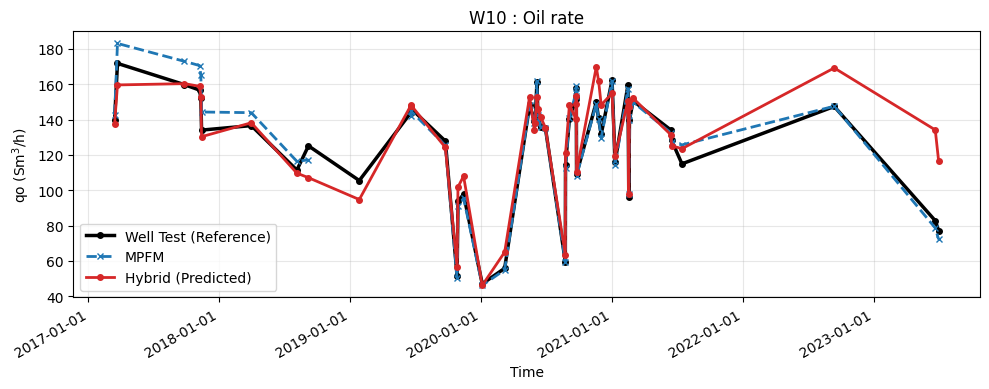

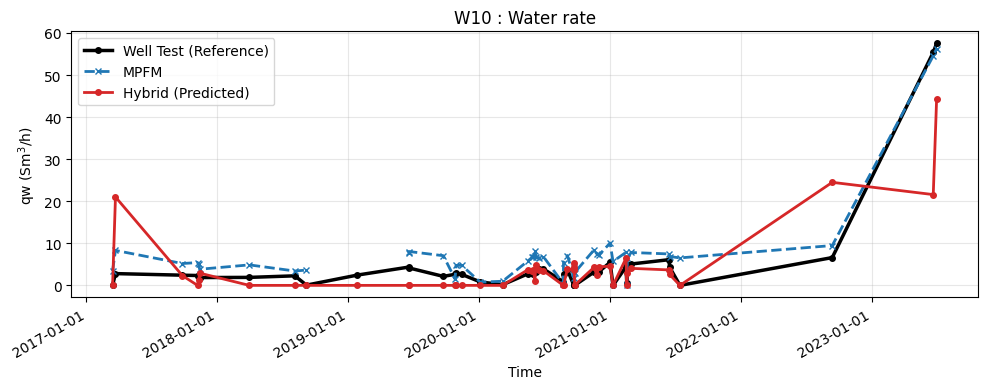

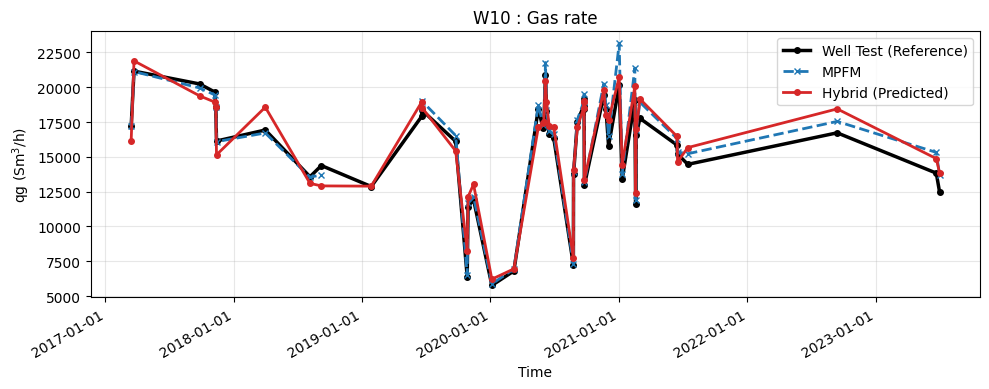

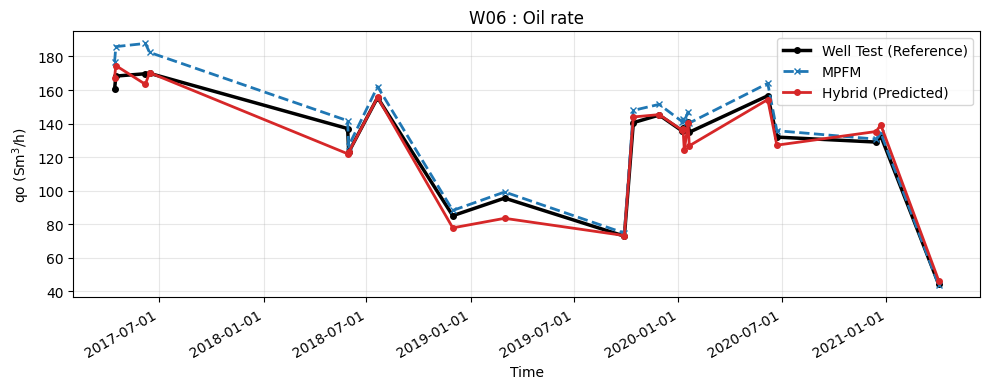

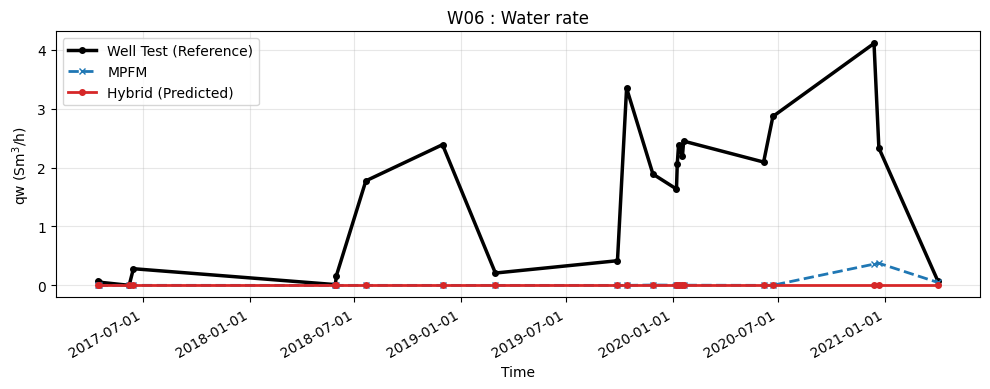

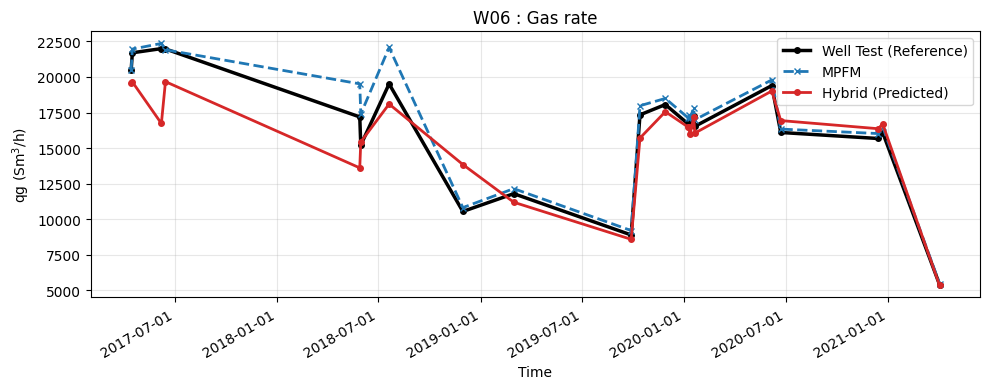

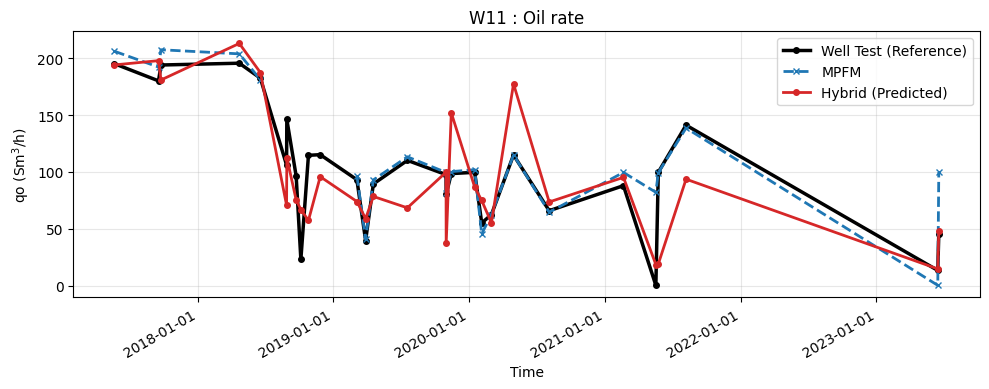

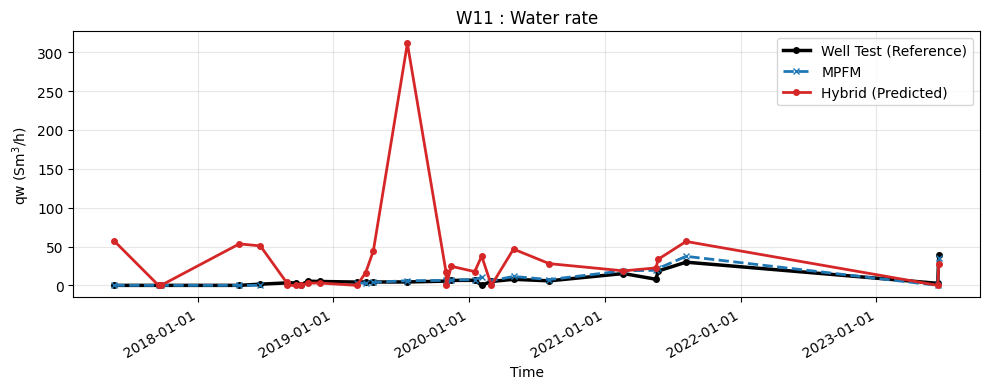

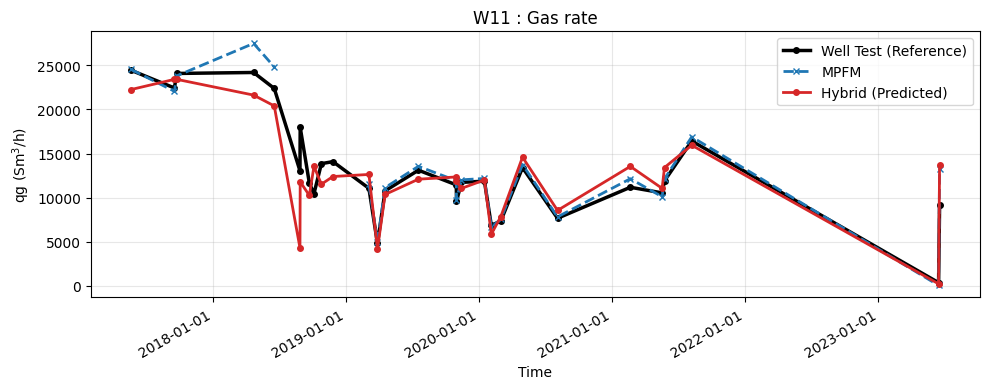

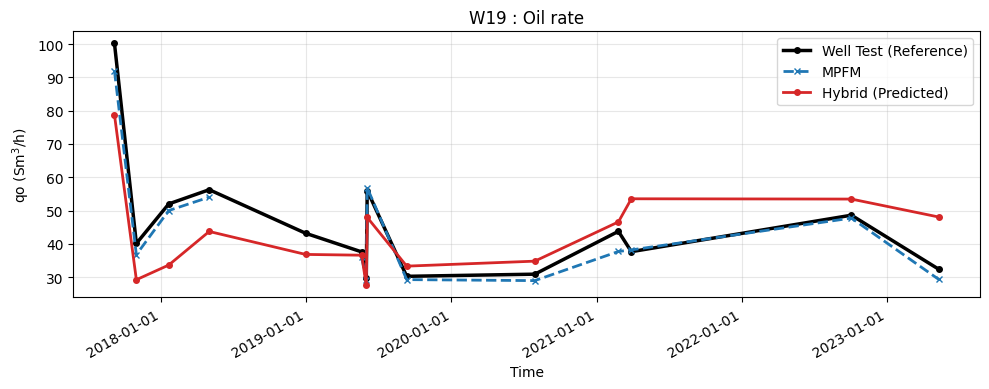

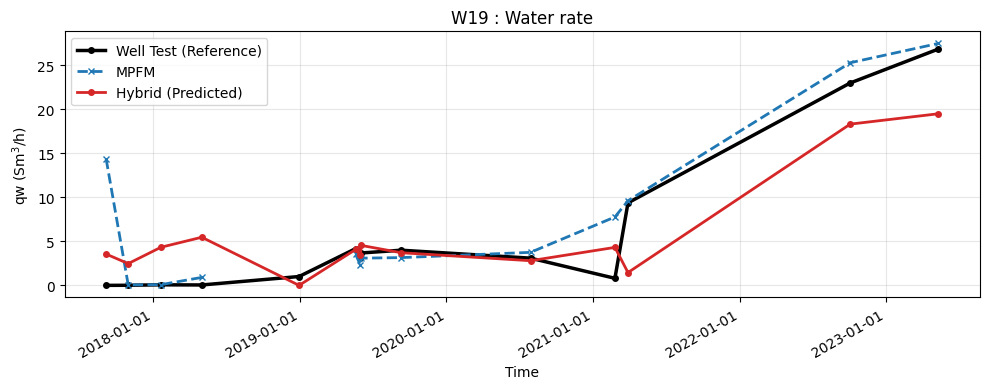

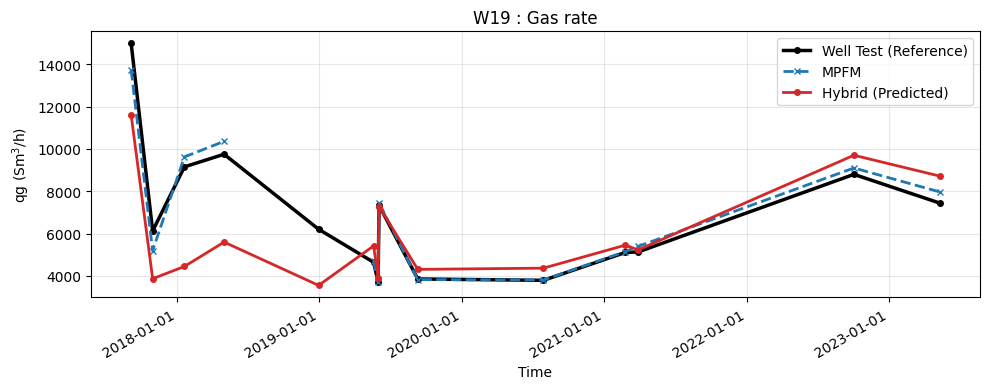

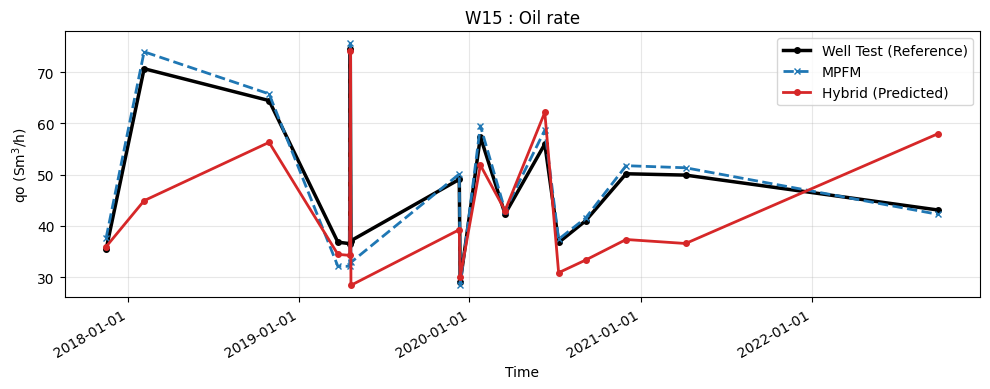

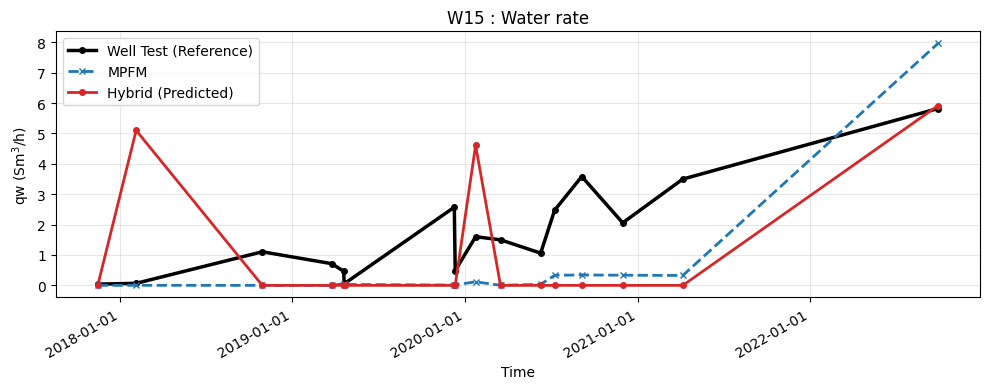

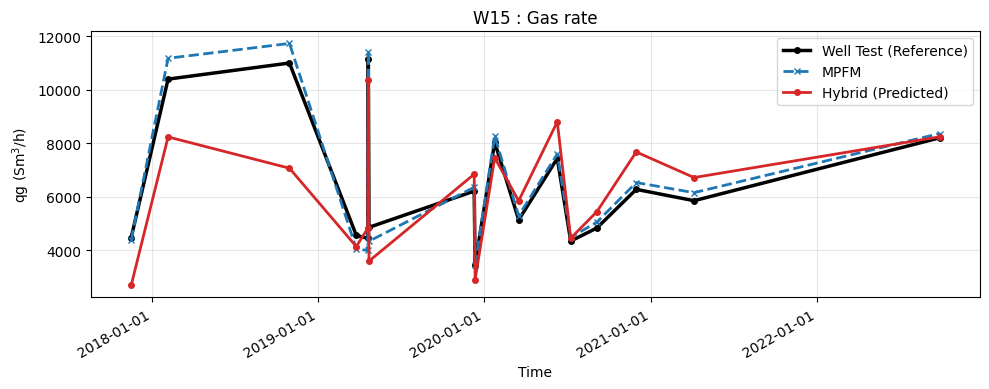

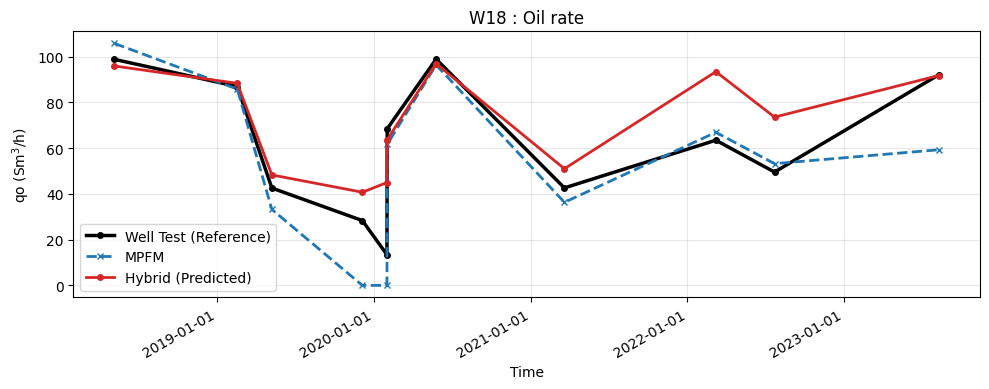

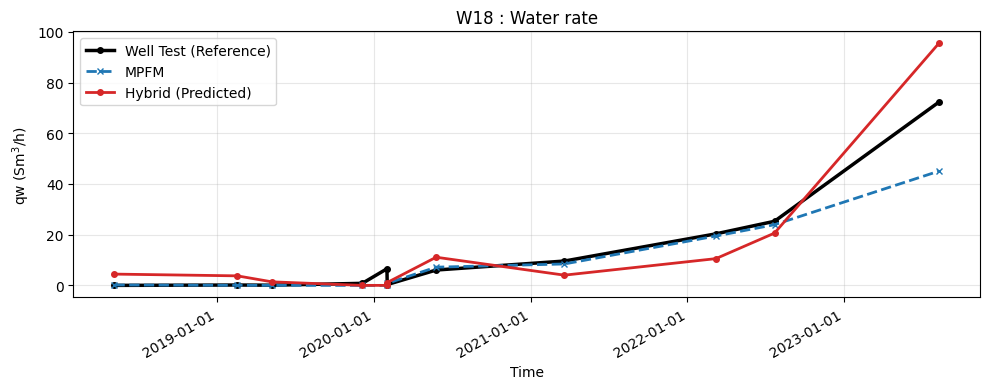

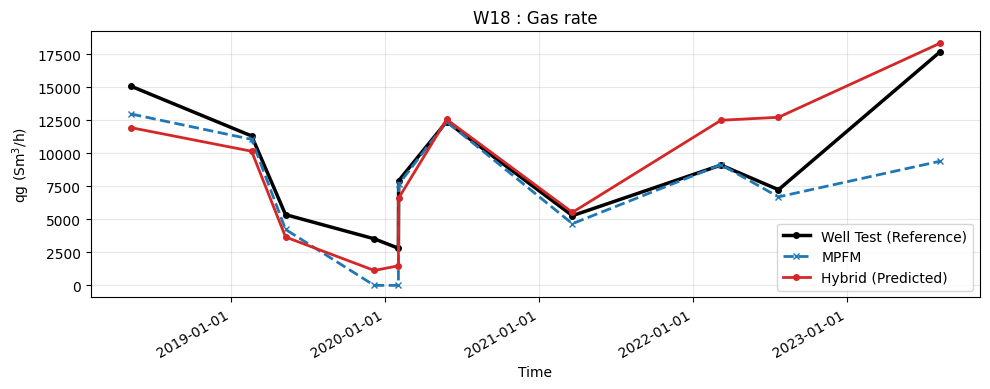

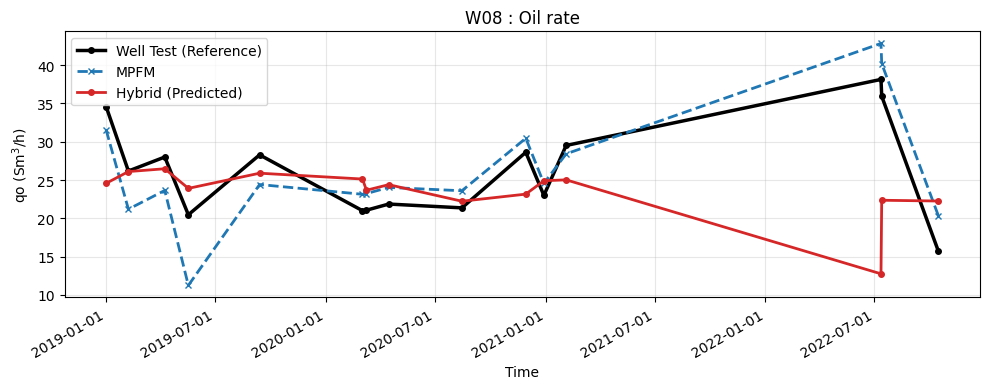

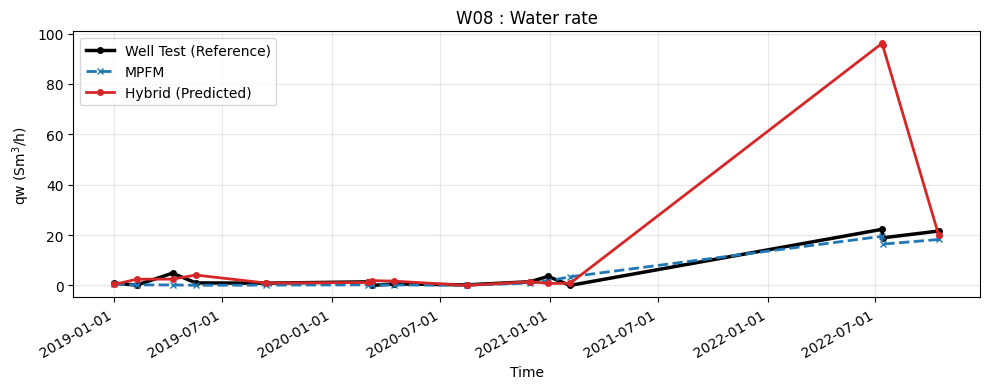

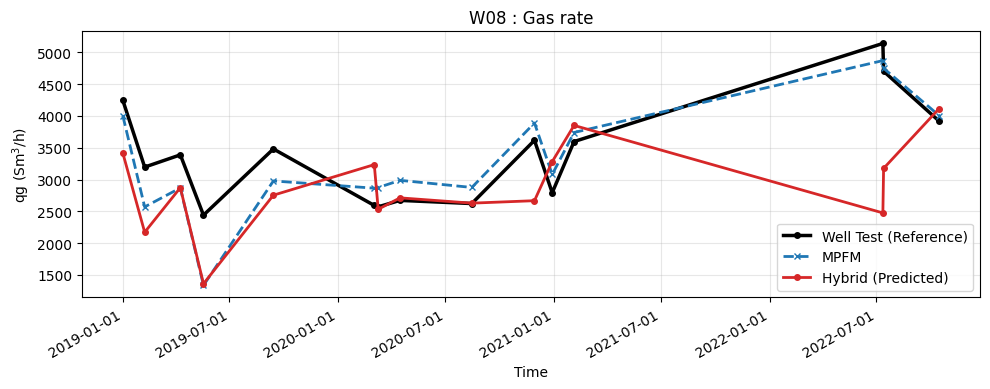

In [633]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [677]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10", is_random=True)
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=410, Val=94, Calibration=20, Test=199


In [678]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[INFO] Regime below_normal: 62 samples
[INFO] Regime normal: 232 samples
[INFO] Regime above_normal: 88 samples
[INFO] Validation ML usage fraction: 1.00


In [679]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)
assert_model(model_lowo)

In [680]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.5046119629283814,
   'mae': 16.566704476888177,
   'rmse': 22.035556409721018,
   'mape (%)': 18.20515242021857,
   'mpe (%)': 8.391388387466598},
  'qw': {'r2': 0.5660984902779782,
   'mae': 3.2419815418637183,
   'rmse': 6.091468313479303,
   'mape (%)': 28487.07929968179,
   'mpe (%)': 28416.76214288667},
  'qg': {'r2': 0.47077050110112795,
   'mae': 2082.14315366102,
   'rmse': 2787.6340862378333,
   'mape (%)': 13.50959391328796,
   'mpe (%)': -7.2679683921395775},
  'wgr': {'r2': 0.3890397999337182,
   'mae': 0.00028970247419654924,
   'rmse': 0.000636752843453171,
   'mape (%)': 124.27761167722755,
   'mpe (%)': 54.21962864719665},
  'gor': {'r2': -5.26561420839211,
   'mae': 15.254315551672883,
   'rmse': 23.427653571876082,
   'mape (%)': 11.994213956057468,
   'mpe (%)': -11.44313710265214}}}

In [681]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.6940140917554085,
   'mae': 12.908442032086887,
   'rmse': 17.31816913633587,
   'mape (%)': 12.832491812470922,
   'mpe (%)': 4.940053393281573},
  'qw': {'r2': 0.06517165268400138,
   'mae': 5.003624779453391,
   'rmse': 8.94112868438334,
   'mape (%)': 275.9616163722905,
   'mpe (%)': 162.50183125082503},
  'qg': {'r2': 0.7764987441394693,
   'mae': 1463.9187349610722,
   'rmse': 1811.5641951716366,
   'mape (%)': 10.426661894736803,
   'mpe (%)': 4.081466016210424},
  'wgr': {'r2': 0.295164937041857,
   'mae': 0.00034473409147609273,
   'rmse': 0.0006839245342526991,
   'mape (%)': 155.44258280586894,
   'mpe (%)': 41.76592798011456},
  'gor': {'r2': -5.306500065194624,
   'mae': 18.10150678186468,
   'rmse': 23.503967092170154,
   'mape (%)': 14.431766102964962,
   'mpe (%)': 1.8843887325230009}}}

In [682]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9588278324434606,
   'mae': 3.7775654337960396,
   'rmse': 6.386703463994204,
   'mape (%)': 3.1903888107563434,
   'mpe (%)': 0.9499826838994622},
  'qw': {'r2': 0.8994164540215364,
   'mae': 2.5206027047414103,
   'rmse': 2.9609717675839393,
   'mape (%)': 88600.43699078905,
   'mpe (%)': 88588.56746999681},
  'qg': {'r2': 0.9532305562723639,
   'mae': 471.4473208049708,
   'rmse': 832.8516834943823,
   'mape (%)': 3.2136350437885124,
   'mpe (%)': 2.3903982015010774},
  'wgr': {'r2': 0.9345019018486344,
   'mae': 0.00016832966902996047,
   'rmse': 0.00021060339151731313,
   'mape (%)': 97.22191065417772,
   'mpe (%)': 84.20382654206995},
  'gor': {'r2': 0.17433999178527682,
   'mae': 6.493567990367629,
   'rmse': 8.588717803460955,
   'mape (%)': 5.118199571690725,
   'mpe (%)': 1.6226874836038174}}}

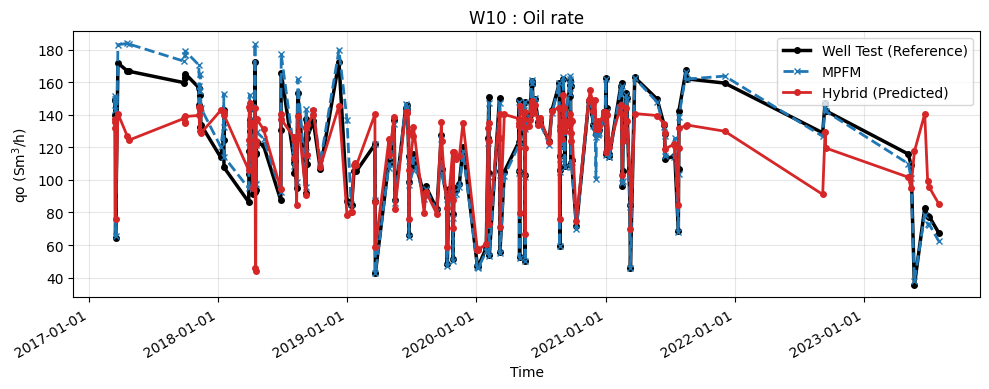

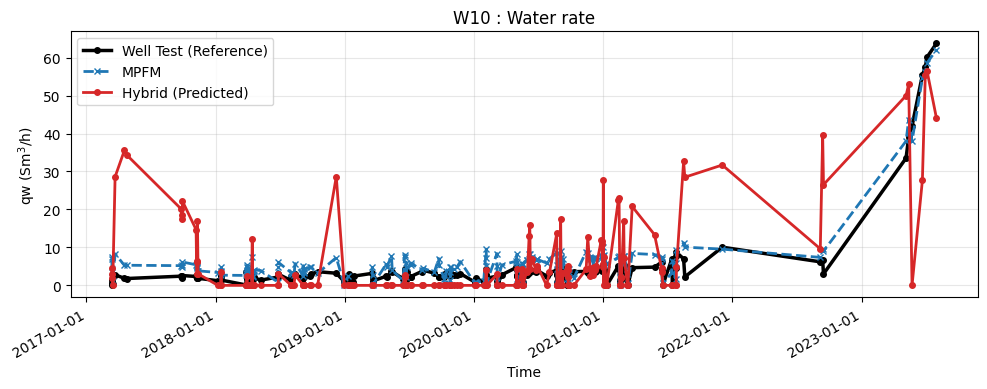

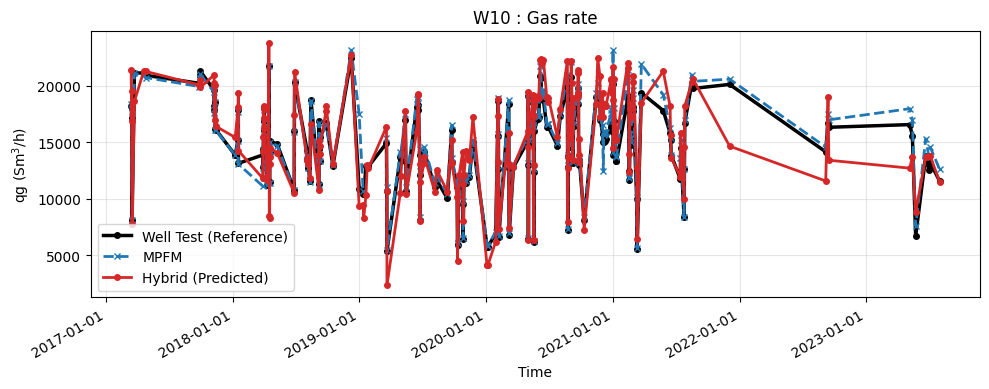

In [683]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [684]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [685]:
# df_resampled.index

In [686]:
# df_resampled.columns

In [687]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [688]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [689]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [690]:
# summarize_null(df_generated)